In [128]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.integrate import simps
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

import snntorch as snn
import sys
import sklearn as sk
import platform
import torch.nn as nn
from fastai.tabular.all import *

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
default_device(torch.device(device))

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.3-arm64-arm-64bit
PyTorch Version: 2.0.0.dev20230210

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [3]:
# load batch_stft.npy and train_idx.npy
reconstructed_stft = np.load('preprocessed_data/reconstructed_stft.npy')
source_stft = np.load('preprocessed_data/source_stft.npy')
train_idx = np.load('preprocessed_data/train_idx.npy')
val_idx = np.load('preprocessed_data/val_idx.npy')
test_idx = np.load('preprocessed_data/test_idx.npy')
labels = np.load('preprocessed_data/labels.npy')
freqs = np.load('preprocessed_data/freq.npy')
times = np.load('preprocessed_data/time.npy')



In [4]:
train_stft = source_stft[train_idx]
val_stft = source_stft[val_idx]
# train_stft = reconstructed_stft[train_idx]
# val_stft = reconstructed_stft[val_idx]

y_train = labels[train_idx]
y_val = labels[val_idx]

welch_train = np.mean(train_stft, axis=3)
welch_val = np.mean(val_stft, axis=3)

print(welch_train.shape)
print(y_train.shape)

(3725, 4, 81)
(3725,)


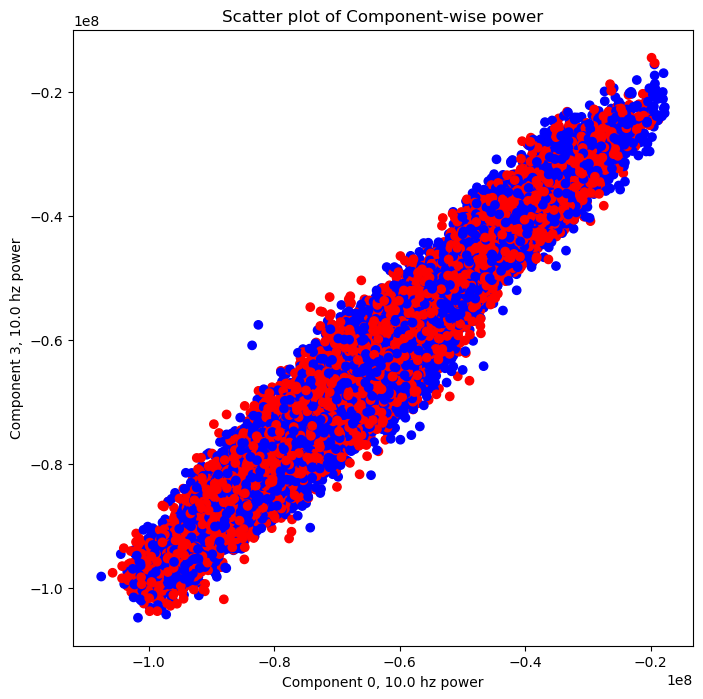

In [135]:
scaling_factor = 1e6
f = 10
train_flat = np.moveaxis(welch_train[:, :, :f], 1, 0).reshape(4, -1)
labels_flat = (y_train.reshape(-1, 1) * np.ones((1, f))).flatten() 

i = 0
j = 3
plt.figure(figsize=(8, 8))
plt.scatter(train_flat[i, :]*scaling_factor, train_flat[j, :]*scaling_factor, c=labels_flat[:], cmap='bwr')

# Add labels and a title
plt.xlabel('Component {}, {} hz power'.format(i, freqs[f]))
plt.ylabel('Component {}, {} hz power'.format(j, freqs[f]))
plt.title('Scatter plot of Component-wise power')

plt.show();

In [5]:
# numerical integration over PSD as a means of dim reduction and calculating band powers
# bandpower is calculated using the non-log-transformed PSD

def abs_band_power(low, high, freqs, psd):
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return simps(psd[:, :, idx_band], dx=freq_res)

def rel_band_power(low, high, freqs, psd):
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return simps(psd[:, :, idx_band], dx=freq_res) / simps(psd, dx=freq_res)

def featurize(welch, freqs, times, log=True):
    welch = 10**(welch/10) if log else welch
    mu = abs_band_power(7, 12, freqs, welch)
    beta = abs_band_power(13, 30, freqs, welch)
    mu_beta_ratio = mu / beta
    rel_mu = rel_band_power(7, 12, freqs, welch)
    rel_beta = rel_band_power(13, 30, freqs, welch)
    return np.concatenate([mu, beta, mu_beta_ratio, rel_mu, rel_beta], axis=1)

def featurize_log(welch, freqs, times):
    mu = abs_band_power(7, 12, freqs, welch)
    beta = abs_band_power(13, 30, freqs, welch)
    mu_beta_ratio = mu / beta
    return np.concatenate([mu, beta, mu_beta_ratio], axis=1)
    


In [6]:
# partion train, test, val
scaler = StandardScaler()

# log psd features in sensorimotor range
X_train = welch_train[:, :, np.logical_and(freqs >= 8, freqs <= 30)]
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
print(X_train.shape)

X_val = welch_val[:, :, np.logical_and(freqs >= 8, freqs <= 30)]
X_val = scaler.fit_transform(X_val.reshape(X_val.shape[0], -1))
print(X_val.shape)

# band power features
# features_train = featurize(welch_train, freqs, times)
# X_train = scaler.fit_transform(features_train)

# features_val = featurize(welch_val, freqs, times)
# X_val = scaler.fit_transform(features_val)

# print(X_train.shape)
# print(X_val.shape)

# # shuffle split the remaining data between test and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# test_idx, val_idx = next(sss.split(source_stft[~train_idx], labels[~train_idx]))



(3725, 92)
(466, 92)


In [96]:
# export test idx
np.save('preprocessed_data/test_idx.npy', test_idx)

# Logistic Regression Prelim Tests

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       237
           1       0.63      0.65      0.64       229

    accuracy                           0.64       466
   macro avg       0.64      0.64      0.64       466
weighted avg       0.64      0.64      0.64       466

ROC AUC: 0.6417095056473753


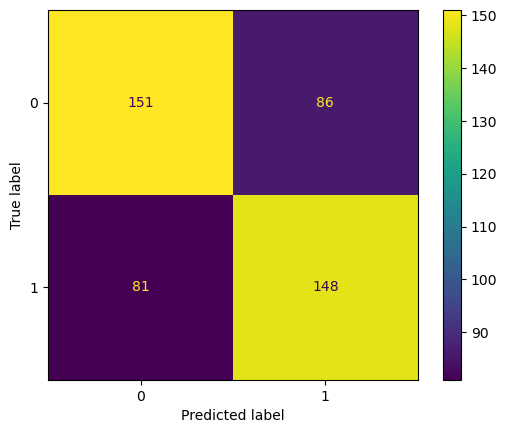

In [126]:
# train logistic regression model

# Fit a logistic regression model
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_val)

# Compute accuracy score
# accuracy = accuracy_score(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
roc = roc_auc_score(y_val, y_pred)

# print('Accuracy:', accuracy)
print(class_report)
print('ROC AUC:', roc)
ConfusionMatrixDisplay(confusion).plot();




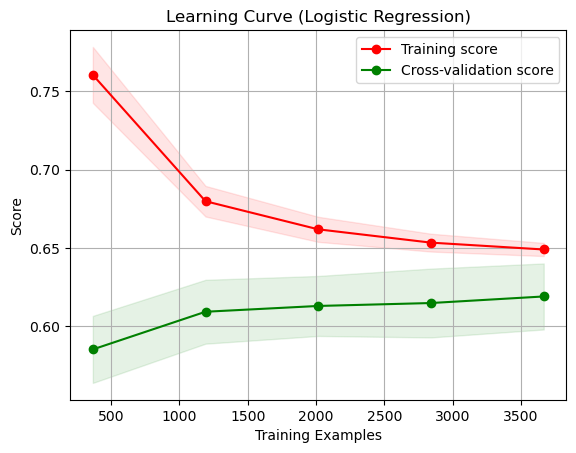

In [127]:
# create a logistic regression classifier
# clf = LogisticRegression(solver='lbfgs', max_iter=1000)

# merge train and val 
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

# set the common parameters for learning curve
common_params = {
    "estimator": clf,
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.125, random_state=0), # 10% of overall data used for validation
    "n_jobs": -1,
    "shuffle": True,
}

# calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(**common_params)

# plot the learning curve
plt.figure()
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [128]:
print(np.mean(test_scores[-1]))

0.6188931297709924


(6724, 92)
(82, 82)


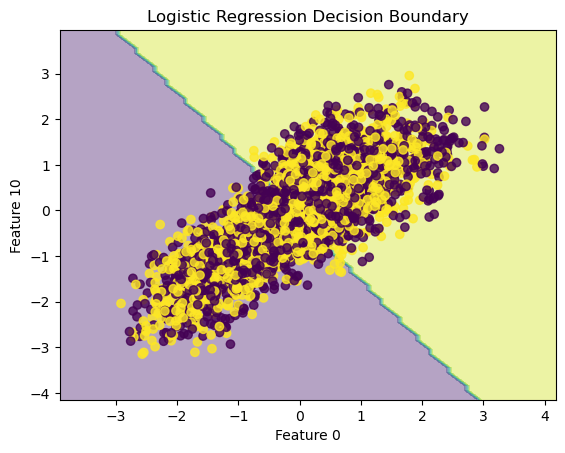

In [129]:
# Extract the coefficients and intercept of the logistic regression model
coef = clf.coef_.ravel()
intercept = clf.intercept_ 

# Select two features to plot the decision boundary
i = 0
j = 10

# Create a grid of points to evaluate the decision boundary
xmin, xmax = X[:, i].min() - 1, X[:, i].max() + 1
ymin, ymax = X[:, j].min() - 1, X[:, j].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.1), np.arange(ymin, ymax, 0.1))

# Create input vector for model
# Fill with zeros for features that are not i or j
X_pred = np.zeros((len(xx.ravel()), X_train.shape[1]))
X_pred[:, i] = xx.ravel()
X_pred[:, j] = yy.ravel()
print(X_pred.shape)

Z = clf.predict(X_pred)
# Reshape the predictions to match the shape of the meshgrid
Z = Z.reshape(xx.shape)
print(Z.shape)

# Plot the decision boundary and the training data
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, i], X[:, j], c=y, alpha=0.8)
plt.xlabel('Feature {}'.format(i))
plt.ylabel('Feature {}'.format(j))
plt.title('Logistic Regression Decision Boundary')
plt.show()



(4191, 2)


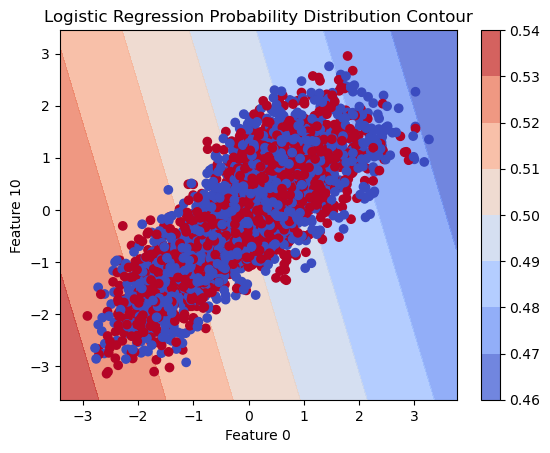

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# build data from 2 features
i = 0
j = 10
X_ij = X[:, [i, j]]
print(X_ij.shape)

# Fit the logistic regression model to the training set
clf = LogisticRegression().fit(X_ij, y)

# Create a meshgrid of feature values
h = 0.02  # step size in the mesh
x_min, x_max = X_ij[:, 0].min() - 0.5, X_ij[:, 0].max() + 0.5
y_min, y_max = X_ij[:, 1].min() - 0.5, X_ij[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Calculate predicted probabilities for each point in the meshgrid
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the probability distribution contour
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar()

# Plot the training set points
plt.scatter(X_ij[:, 0], X_ij[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Feature {}'.format(i))
plt.ylabel('Feature {}'.format(j))
plt.title('Logistic Regression Probability Distribution Contour')
plt.show()


Verdict: Log reg alone sucks as expected, pretty much dummy classifier level.

# Single Linear Layer NN Test
Basic linear layer followed by a sigmoid 

In [118]:
# create a pandas dataframe from the numpy arrays
train_df = pd.DataFrame(data=np.c_[X_train, y_train], columns=[f'feat_{i}' for i in range(X_train.shape[1])] + ['label'])
valid_df = pd.DataFrame(data=np.c_[X_val, y_val], columns=[f'feat_{i}' for i in range(X_val.shape[1])] + ['label'])

# merge the train and validation set
combined_df = pd.concat([train_df, valid_df], axis=0)
val_df_idx = np.arange(len(train_df), len(combined_df))

# define your dependent and independent variables
dep_var = 'label'
cat_names = []
cont_names = [f'feat_{i}' for i in range(X_train.shape[1])]

# define your processors, which can be used to normalize your data
procs = [Normalize]

dls = TabularDataLoaders.from_df(combined_df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=dep_var, valid_idx=val_df_idx, bs=64)

# create TabularPandas object for train and validation set
# train_tlp = TabularPandas(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=dep_var, splits=None)
# valid_tlp = TabularPandas(valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=dep_var, splits=None)

# # create DataLoader for train and validation set
# train_dl = DataLoader(train_tlp, bs=64)
# valid_dl = DataLoader(valid_tlp, bs=64)

# # create dataloaders
# dls = DataLoaders(train_dl, valid_dl)




In [134]:
# combined_df.head()
dls.show_batch()
batch = dls.one_batch()  
print(batch[1].size())


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,label
0,1.169362,1.037807,0.434315,0.899832,0.409192,0.792708,0.573586,1.054300,1.031205,0.677635,1.002241,1.043642,1.192973,0.973532,0.817785,0.961457,0.441791,1.024194,1.017733,0.968170,1.217493,1.478327,1.096378,1.417882,1.003758,0.827707,1.105569,1.600675,1.551022,1.280344,0.730980,1.285771,0.963417,1.494560,1.277899,0.977072,1.226332,1.313434,1.389002,1.000332,0.838196,0.754508,0.884688,0.927040,0.964325,1.103573,1.435343,1.084478,1.656921,1.648378,0.781891,0.457224,0.662763,1.074584,0.835118,0.651759,0.968231,0.859817,1.392461,1.338887,0.980051,0.341899,0.083326,0.675313,0.739558,0.510000,0.809914,0.366399,0.552563,1.452489,1.333673,1.945658,1.783390,1.829844,1.676981,0.595572,1.237347,1.546661,1.596904,1.639137,1.245705,1.456398,1.636571,1.190397,1.011021,1.041633,1.662425,1.660560,1.266445,1.632264,1.389201,1.758667,1.0
1,0.388191,0.009773,0.006722,-0.025115,-0.014185,0.448567,0.735574,0.666335,0.746829,1.132497,1.384500,1.653496,1.368133,1.333108,0.703540,1.305046,0.530430,0.044061,0.148949,0.627100,0.827255,0.781475,0.375162,1.054933,1.014931,0.875282,0.921361,0.906055,1.031687,1.018688,1.081790,0.879083,1.400109,1.316320,1.229744,0.906140,0.820690,0.745755,0.795257,0.812601,0.257483,0.862046,0.752720,0.861960,1.160429,0.825443,1.603812,1.430196,0.737418,0.758193,0.502051,0.633288,0.763239,1.387705,1.446706,1.034823,0.944027,0.186146,1.157961,1.024195,0.850653,0.654391,0.474788,1.036204,0.915610,0.710777,1.334220,1.511668,1.563658,0.447361,0.194016,0.090705,0.623162,0.200231,0.270404,0.719927,0.835600,0.720240,0.949971,0.889894,0.899741,0.649600,0.119087,0.231999,0.536325,0.388060,0.699174,0.706474,0.298841,0.246309,-0.101689,0.171470,1.0
2,-0.531078,0.510423,0.899789,1.030536,-0.028139,-0.570640,-0.079318,-0.071667,-0.572139,-0.989070,-0.721317,-0.197489,0.214255,-0.484427,-0.903483,-0.816045,-0.833208,-0.846318,-1.035576,-0.963088,-1.200065,-1.655358,-1.433832,-0.983980,-1.198037,-0.168605,0.293837,-0.570551,-1.012810,-2.274598,-1.302288,-0.490858,-0.666875,-0.197813,-0.336270,-0.183119,-0.780075,-1.058660,-0.877963,-1.134221,-1.045719,-0.873923,-1.012846,-1.058212,-1.453475,-1.217305,-1.274706,-0.710118,0.184750,0.776619,0.228446,-0.608380,-0.655500,-0.812031,-0.403893,-0.518066,-0.506118,-0.875935,-1.235133,-0.756955,-0.107234,-0.921894,-0.515666,-0.885324,-0.821553,-1.933854,-1.759527,-1.238095,-1.039843,-0.786561,0.023443,0.644784,0.598613,-0.094055,-1.384095,-0.491075,-0.316497,-1.427581,-1.639342,-1.329864,-0.988583,-0.635560,-0.974998,-1.293043,-1.314337,-0.999824,-1.655610,-1.532507,-2.077716,-1.141275,-1.436905,-1.095808,1.0
3,0.379372,0.921901,1.127655,1.063967,0.734677,0.321078,0.679077,0.725733,0.470603,1.014204,0.689339,0.303740,1.035671,0.527229,0.845525,0.774010,0.485449,0.679971,0.105400,0.383029,0.447143,0.520107,1.153028,0.791837,0.998887,0.384978,0.081711,0.386289,0.800879,0.669151,0.804340,1.068660,0.430828,0.959518,1.243737,1.576242,1.599459,1.376203,1.526141,1.676056,1.500282,1.489679,1.705318,1.073984,1.164175,1.400669,1.119866,1.262124,1.118045,0.960574,1.039535,0.922363,1.396646,1.588073,1.821604,2.152736,1.779324,1.791166,1.564655,1.417126,1.451489,1.277638,1.161894,0.416142,0.542991,0.412129,0.342146,0.934271,0.608465,0.253584,0.819419,1.097199,0.769320,0.675298,0.699835,0.60

torch.Size([64, 92])


In [126]:
# define neural network architecture
class LogNet(torch.nn.Module):
    def __init__(self):
        super(LogNet, self).__init__()
        self.lin = torch.nn.Linear(92, 1)
        self.sig = torch.nn.Sigmoid()
        
    def forward(self, xb):
        out = self.lin(xb)
        out = self.sig(out)
        return out

print(X_train.shape[1])
learn = Learner(dls, model=LogNet(), opt_func=SGD, loss_func=torch.nn.BCELoss(), metrics=[accuracy])

# train model
learn.fit_one_cycle(10)

# Define neural network architecture
# net = nn.Sequential(
#         nn.Linear(92, 1),
#         nn.Sigmoid()
# )

# # Create a learner object
# learn = Learner(dls, net, opt_func=SGD, loss_func=torch.nn.BCEWithLogitsLoss(), metrics=[accuracy])

# # Train the model
# learn.fit(10)

TypeError: forward() takes 2 positional arguments but 3 were given

In [138]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(92, 1)
        
    def forward(self, x):
        x = self.fc(x)
        x = nn.Sigmoid()(x)
        return x

# Initialize the model and optimizer
model = Net()

# define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train model
for epoch in range(10):
    for _, xb, yb in dls.train:
        # forward pass
        pred = model(xb)
        loss = criterion(pred.squeeze(), yb.squeeze())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate on validation set
    with torch.no_grad():
        val_loss = sum(criterion(model(xb).squeeze(), yb.squeeze()) for _, xb, yb in dls.valid) / len(dls.valid)
        print(f"Epoch {epoch+1}, training loss: {loss}, validation loss: {val_loss}")


Epoch 1, training loss: 0.6833249926567078, validation loss: 0.6762050986289978
Epoch 2, training loss: 0.6797870397567749, validation loss: 0.6662325859069824
Epoch 3, training loss: 0.6781250238418579, validation loss: 0.6608609557151794
Epoch 4, training loss: 0.6259390115737915, validation loss: 0.653788149356842
Epoch 5, training loss: 0.658774733543396, validation loss: 0.650148868560791
Epoch 6, training loss: 0.719247043132782, validation loss: 0.6467692852020264
Epoch 7, training loss: 0.6506668329238892, validation loss: 0.6442252993583679
Epoch 8, training loss: 0.6036391854286194, validation loss: 0.6433281898498535
Epoch 9, training loss: 0.6587581634521484, validation loss: 0.6403239965438843
Epoch 10, training loss: 0.6154803037643433, validation loss: 0.6381287574768066


# CNN Sensor Fusion
Compressing 4xn sensor data into a single 1xn vector. 

# Single RNN Layer Test
Instead of using welch, pass in individual STFT time frames to a single RNN layer.

# Legendre Memory Unit